[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.10.1. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

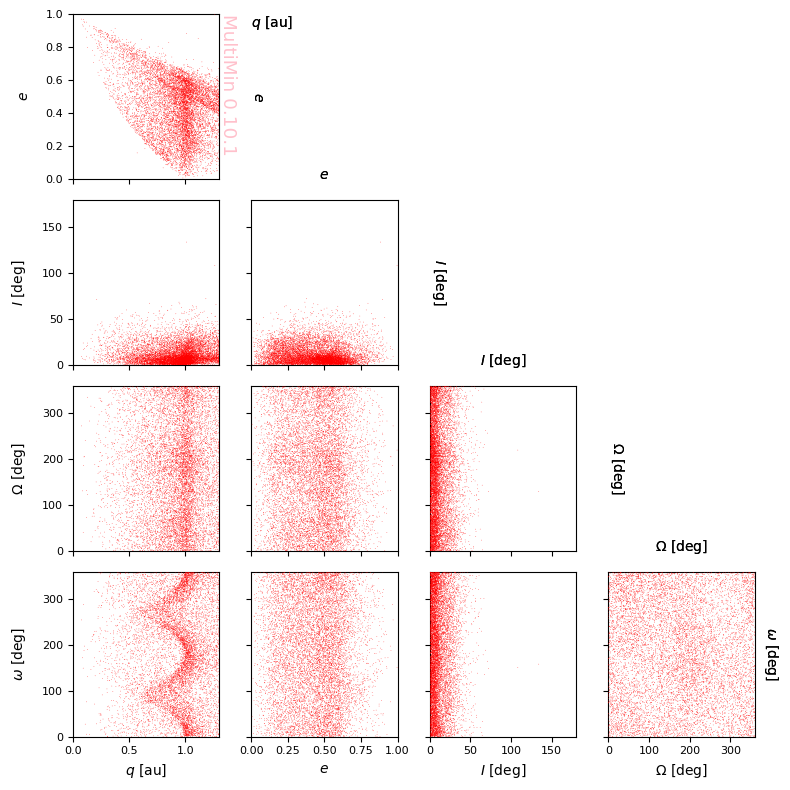

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

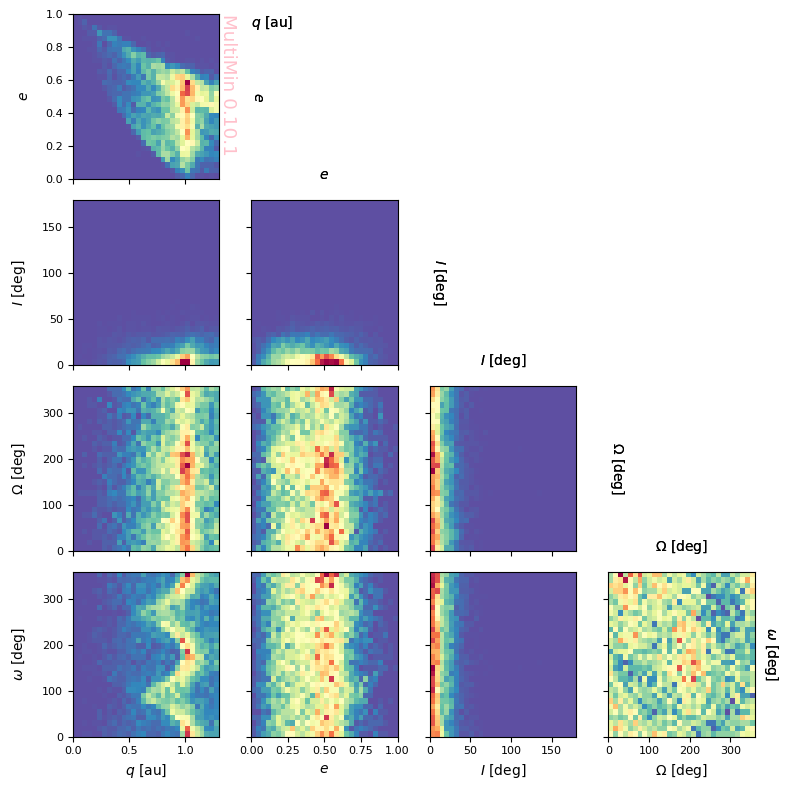

In [5]:
G=mn.MultiPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

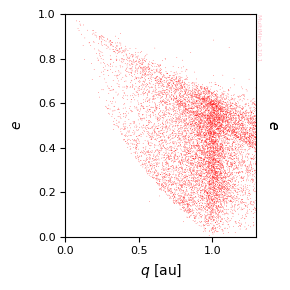

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.30579193769202473
Elapsed time since last call: 132.086 ms
-log(L)/N = -0.5312330475196455


And check the fit result:

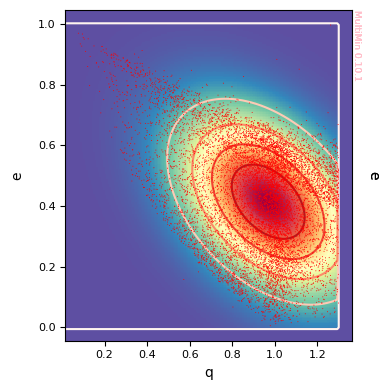

In [9]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(properties=properties,pargs=hargs,sargs=sargs,cargs=cargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.968818,0.41412,0.265829,0.189959,-0.423586


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.2454740267377441
Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.48, 0.14, 0.81, 0.32, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.76, 0.62, 0.68, 0.41, 1.1]
	LogL/N: 2.0788213621191516


Iter 50:
	Vars: [-2.1, -1.4, -0.91, -0.7, -1.9, 0.94, 0.17, 0.7, 0.36, 1, 0.35, 1.1, 0.52, 1, 0.53, -4.4, -4.9, -4, -4.1, -4.4, -4.5, -3.2, -4.1, -4, -4.8, -0.95, -2, -1.2, -3.5, 0.54]
	LogL/N: -0.6906559529279813


Iter 100:
	Vars: [-2.1, -1.9, -0.41, -0.78, -1.9, 0.94, 0.17, 0.64, 0.38, 1, 0.36, 1.1, 0.52, 0.96, 0.54, -4.4, -4.9, -4.1, -4.2, -4.4, -4.3, -3.2, -4.1, -3.9, -5, -0.83, -2.1, -0.74, -3.6, 0.22]
	LogL/N: -0.6954710878579823


Iter 150:
	Vars: [-2.3, -1.9, -0.18, -0.8, -1.9, 0.94, 0.16, 0.64, 0.36, 1, 0.35, 1.1, 0.52, 0.97, 0.55, -4.3, -5, -4.1, -4.2, -4.4, -4.3, -3.1, -4.1, -3.7, -5.2, -0.89, -2.1, -0.64, -3.7, -0.049]
	LogL/N: -0.6972292891062186


Iter 200:
	Vars: [-3, -1.8, 0.074, -0.86, -1.6, 0.9, 0.15, 0.65, 0.35, 1, 0.34, 1.1, 0.51, 0.98, 0.55, -4.5, -5.2, -4.1, -4.2, -4.3, -4.3, -3.1, -4, -3.7, -5.1, -1.3, -2.3, -0.64, -3.9, -0.65]
	LogL/N: -0.6984108425024552


Iter 250:
	Vars: [-3.5, -1.9, -0.038, -1.1, -0.58, 0.77, 0.18, 0.69, 0.33, 1, 0.31, 1, 0.56, 1, 0.52, -4.8, -5.3, -4.2, -4.5, -4.4, -4.3, -3.2, -4.1, -3.5, -4.8, -2.2, -1.9, -0.27, -3.9, -0.99]
	LogL/N: -0.7016875413941766


Iter 300:
	Vars: [-3.3, -2, 0.052, -1.2, -0.52, 0.76, 0.18, 0.66, 0.35, 1, 0.31, 0.99, 0.58, 1, 0.51, -4.9, -5.3, -4.2, -4.5, -4.4, -4.2, -3.2, -4.2, -3.5, -4.7, -2.8, -2, -0.46, -3.9, -1.4]
	LogL/N: -0.7044556090154661


Iter 350:
	Vars: [-3, -1.9, 0.38, -2.1, -0.36, 0.68, 0.24, 0.66, 0.39, 1, 0.32, 0.74, 0.69, 1.1, 0.51, -4.2, -4.4, -4.1, -4.3, -4.4, -4.2, -3.5, -4.5, -3.4, -4.5, -4.4, -2, -0.46, -4, -2.3]
	LogL/N: -0.7089981701882576


Iter 400:
	Vars: [-2.5, -1.8, 0.2, -2.3, -0.32, 0.69, 0.24, 0.7, 0.38, 1, 0.33, 0.69, 0.71, 1.1, 0.52, -4, -4.3, -4, -4.2, -4.4, -4.2, -3.5, -4.5, -3.5, -4.6, -4.2, -2.2, -0.52, -4.2, -2.1]
	LogL/N: -0.7109996853729833


Iter 450:
	Vars: [-2.4, -1.7, 0.15, -2.3, -0.27, 0.67, 0.26, 0.71, 0.38, 1, 0.33, 0.69, 0.71, 1.1, 0.52, -4.1, -4.3, -4, -4, -4.4, -4.2, -3.5, -4.5, -3.5, -4.6, -4, -2.5, -0.57, -4.3, -2.1]
	LogL/N: -0.7115032635554055
Iter 454:
	Vars: [-2.4, -1.7, 0.16, -2.3, -0.28, 0.67, 0.26, 0.71, 0.38, 1, 0.33, 0.69, 0.71, 1.1, 0.52, -4.1, -4.3, -4, -4, -4.4, -4.2, -3.5, -4.5, -3.5, -4.6, -4, -2.5, -0.57, -4.3, -2.1]
	LogL/N: -0.711553832603506
Elapsed time since last call: 21.6802 s
-log(L)/N = -0.711553832603506


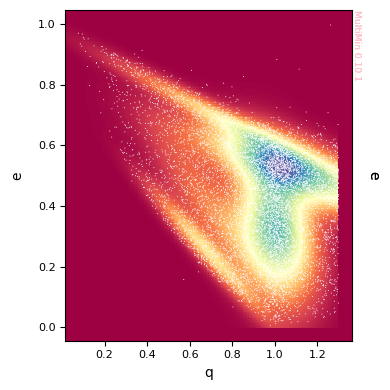

In [12]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='w')
cargs=dict(levels=100)
pargs=dict(cmap='Spectral')
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    #hargs=hargs,
    sargs=sargs,
    #cargs=cargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.mog.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

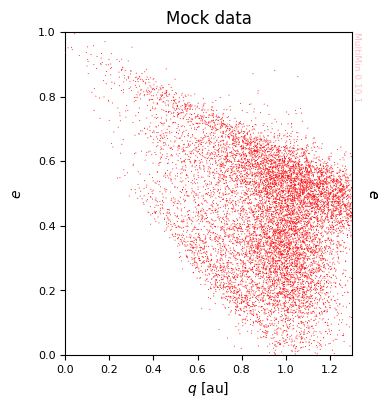

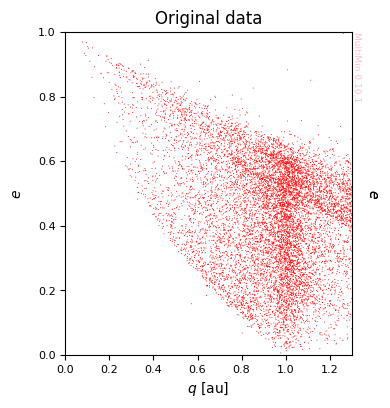

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
3,0.417823,1.005342,0.329474,0.118978,0.144554,-0.276462
5,0.333599,1.092716,0.520716,0.298976,0.100730,-0.782902
2,0.117630,0.714275,0.375609,0.185584,0.175377,-0.853835
4,0.067588,0.693219,0.710261,0.301413,0.112970,-0.974432
1,0.063359,0.668868,0.261451,0.167388,0.131271,-0.964295


In [16]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.668868
    mu1_e = 0.261451
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.028019, -0.021189], [-0.021189, 0.017232]]
    Z1 = 0.976765
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.714275
    mu2_e = 0.375609
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.034441, -0.02779], [-0.02779, 0.030757]]
    Z2 = 0.98361
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.005342
    mu3_e = 0.329474
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.014156, -0.004755], [-0.004755, 0.020896]]
    Z3 = 0.982434
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 0.693219
    mu4_e = 0.710261
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.09085, -0.03318], [-0.03318, 0.012762]]
    Z4 = 0.966949
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.092716
    mu5_e = 0.520716
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.089387, -0.023578], [-0.023578, 0.010147]]
    Z5 = 

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 132.65136794137547
-log(L)/N = 3.4726750888197864


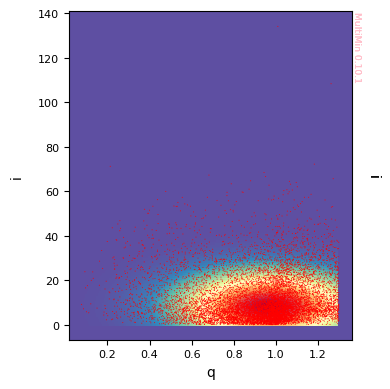

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
pargs=dict(cmap='YlGn')
G=F_qi_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 135.37731680829745
-log(L)/N = 3.3031916482405506


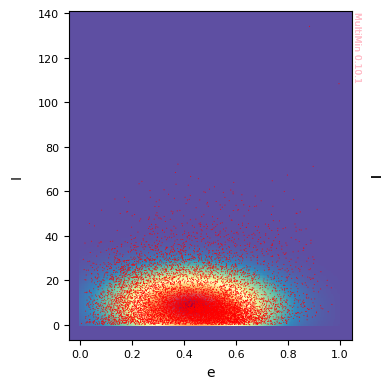

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

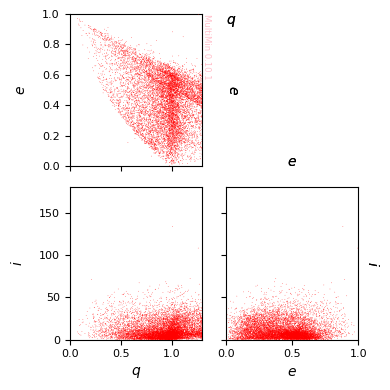

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.59469270670795


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -0.99871484348672


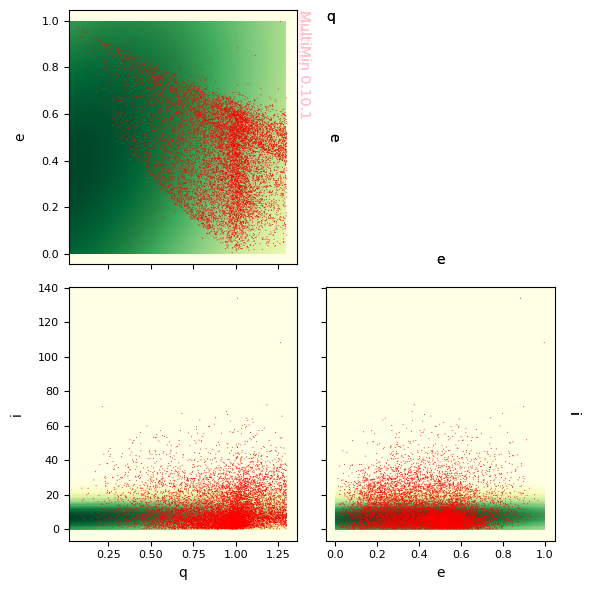

In [21]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.59469249803297


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -2.3669558837463125


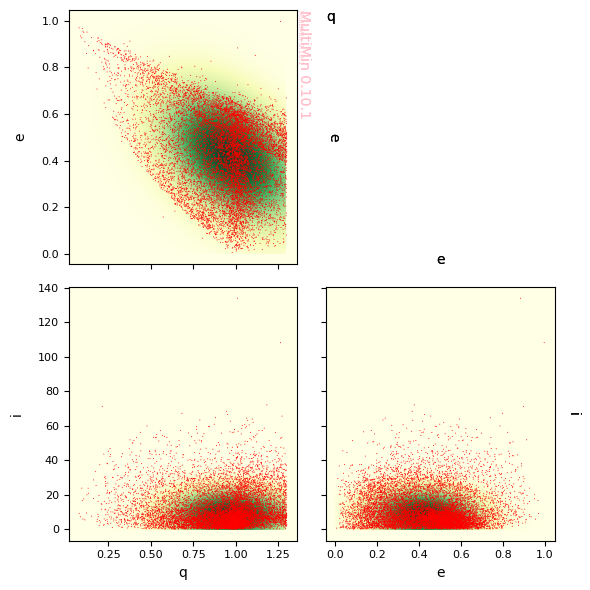

In [23]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 337.7371994944085


Minimizing: 0it [00:00, ?it/s]

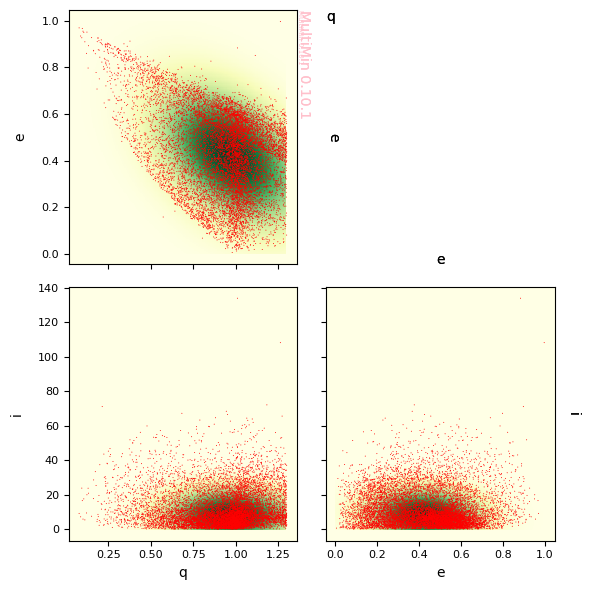

In [24]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [25]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

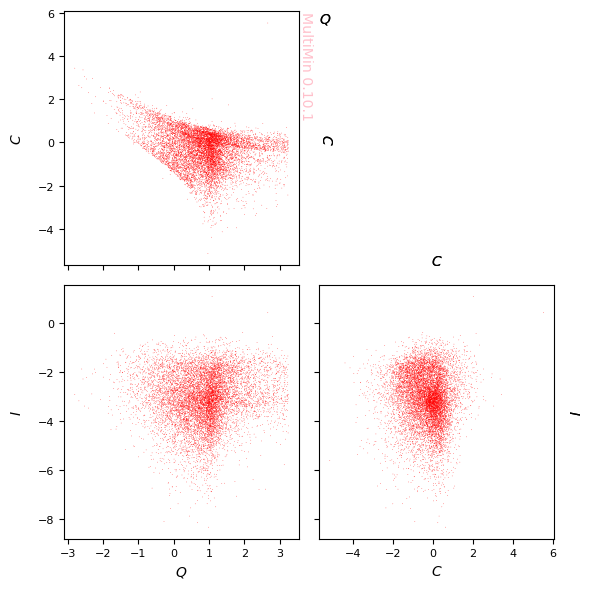

In [26]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

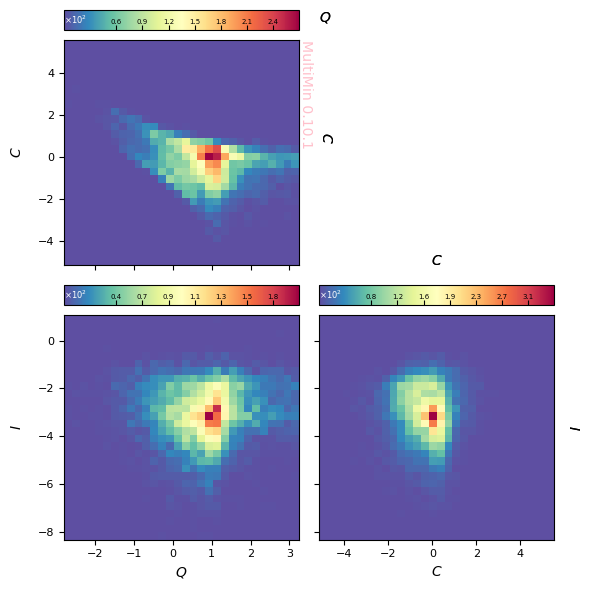

In [27]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [28]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01841867918512


The fitter holds an initial MoG that will be optimized:

In [29]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [30]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 146.847 ms
-log(L)/N = 3.9877266496334807


Inspect the fitted MoG:

In [31]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8565629059050517, -0.3304947025433364, -3.0734315176128377]]
    Standard deviations (σ): [[0.8574293071987665, 0.8707269119636977, 1.0792269415237]]
    Correlation coefficients (ρ): [[-0.30764582213231684, 0.054799775592744515, -0.060778007499428854]]

    Covariant matrices (Σ): 
        [[[0.7351850168433568, -0.2296843015371206, 0.05070956466351442], [-0.2296843015371206, 0.7581653552178369, -0.05711381946431484], [0.05070956466351442, -0.05711381946431484, 1.1647307913105995]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8565629059050517, -0.3304947025433364, -3.0734315176128377, 0.7351850168433568, -0.2296843015371206, 0.05070956466351442, 0.7581653552178369, -0.05711381946431484, 1.1647307913105995]
        With std. and correla

Plot the fit result (fitted sample + data scatter):

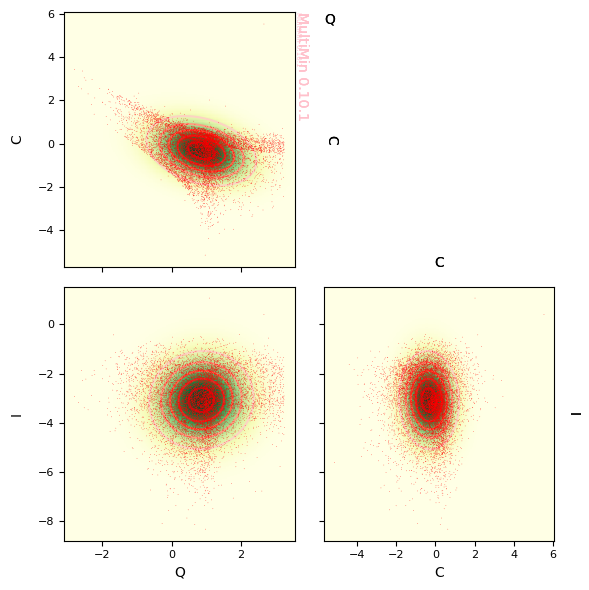

In [32]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [33]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [34]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.9877266496334807
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8565629059050517, -0.3304947025433364, -3.0734315176128377]]
    Standard deviations (σ): [[0.8574293071987665, 0.8707269119636977, 1.0792269415237]]
    Correlation coefficients (ρ): [[-0.30764582213231684, 0.054799775592744515, -0.060778007499428854]]

    Covariant matrices (Σ): 
        [[[0.7351850168433568, -0.2296843015371206, 0.05070956466351442], [-0.2296843015371206, 0.7581653552178369, -0.05711381946431484], [0.05070956466351442, -0.05711381946431484, 1.1647307913105995]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8565629059050517, -0.3304947025433364

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01841867918512


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 923.265 ms
-log(L)/N = 3.896626276105488
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.27524080358948455, 0.7247591964105156]
    Number of variables: 3
    Averages (μ): [[0.45674158906546725, 0.45819955605219254, -3.5213980029666345], [0.9925196212953784, -0.612856208342721, -2.9116123372322216]]
    Standard deviations (σ): [[0.8192433613902989, 0.5454977273669976, 1.1548830206109784], [0.8241703081916297, 0.78426062360987, 0.9983732802303025]]
    Correlation coefficients (ρ): [[-0.8150336251022505, -0.3209714869488117, 0.32597316862280934], [-0.03592104703466514, 0.11708872342948418, 0.026753579095248007]]

    Covariant matrices (Σ): 
        [[[0.6711596851820758, -0.36423477121935455, -0.3036808324893654], [-0.36423477121935455, 0.2975677705625593, 0.20535855318279087], [-0.3036808324893654, 0.20535855318279087, 1.3337547912955374]], [[0.6792566969046859, -0.023218083135331986, 0.09634406910999085],

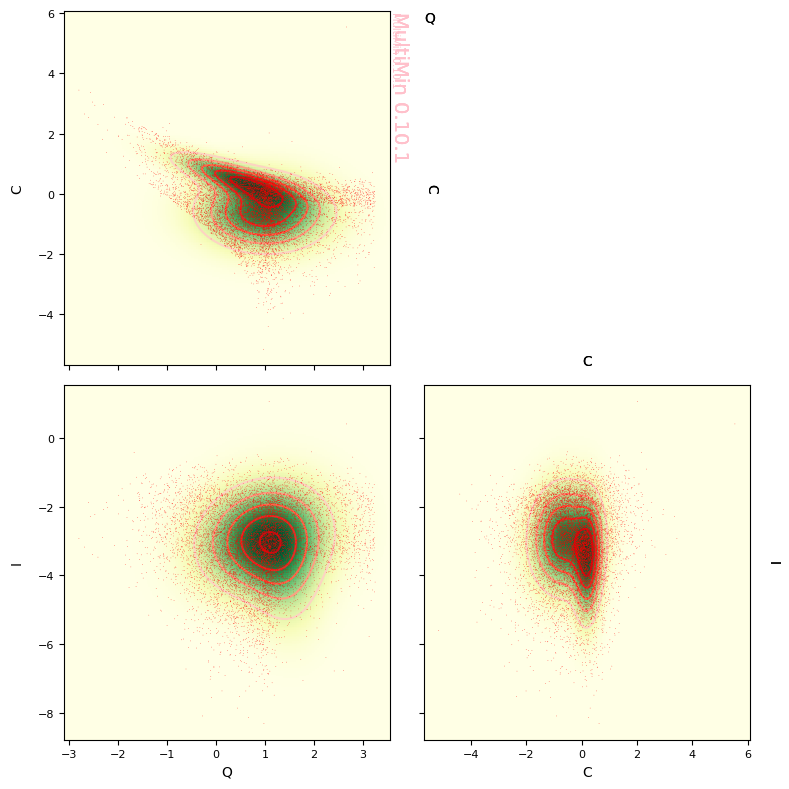

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01841867918512


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 1.02593 s
-log(L)/N = 3.896852552631846
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.286044646353814, 0.7139553536461861]
    Number of variables: 3
    Averages (μ): [[0.4593852825179853, 0.45798483975726295, -3.5128035486227733], [0.991257861269309, -0.6204362650605513, -2.907753995917958]]
    Standard deviations (σ): [[0.8216244314767198, 0.5443225785885578, 1.1481532929471878], [0.8261675753518718, 0.7830649771245013, 0.9991799784361226]]
    Correlation coefficients (ρ): [[-0.8127824846292782, -0.3145636779160147, 0.3246362854026137], [-0.03395828625204034, 0.11780639092491585, 0.030308094231829896]]

    Covariant matrices (Σ): 
        [[[0.6750667063994431, -0.36349967769463526, -0.29674389613275814], [-0.36349967769463526, 0.2962870695612967, 0.2028865631652321], [-0.29674389613275814, 0.2028865631652321, 1.3182559841054708]], [[0.6825528625627908, -0.02196907196598972, 0.09724800943993915], [-0.

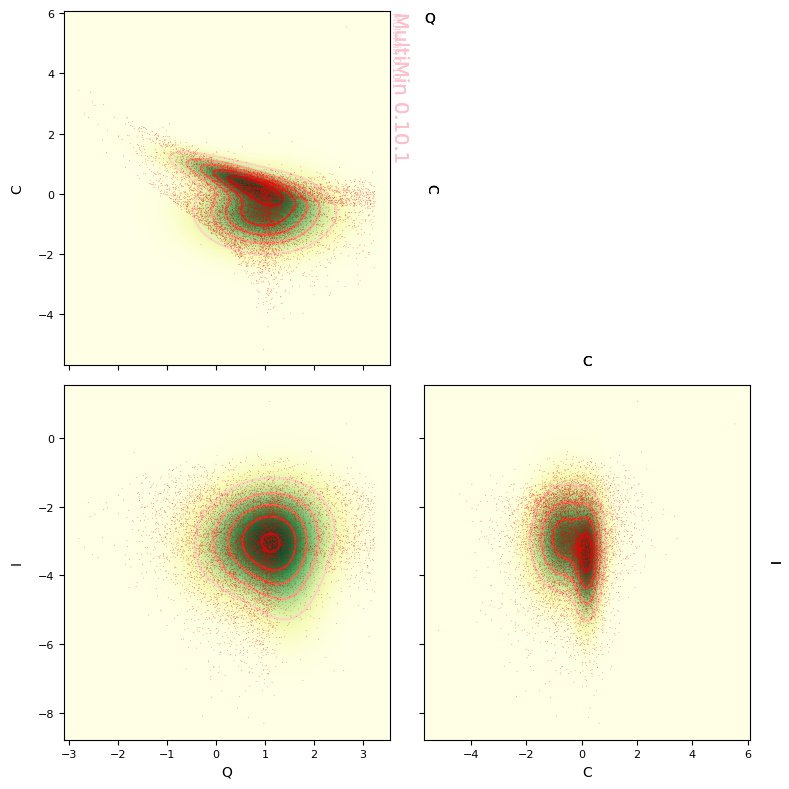

In [36]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.01841867918512


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 9.86357 s
-log(L)/N = 3.7324780231591075
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.13324489004378215, 0.26750886602923407, 0.1333392362794566, 0.22908826983261268, 0.23681873781491453]
    Number of variables: 3
    Averages (μ): [[1.359615812898599, -0.8943520242473246, -3.5208073046415396], [1.0111737289779537, -0.5852987602015037, -2.8936545434337058], [0.5351638274925189, 0.5609056792537008, -3.7340116654287354], [1.350446511202595, 0.1055680455387209, -3.140508117148873], [0.05978910571300158, -0.6057851880125817, -2.617961806381956]]
    Standard deviations (σ): [[0.8054031777588577, 0.7827981592436747, 1.4285214613458623], [0.3416248672703887, 0.5698086677962919, 0.9273591907426507], [0.6438859318616965, 0.38296345122257064, 1.2167688270080186], [0.8872267946063244, 0.27560477283730184, 0.8164987134947577], [0.7244664180376515, 1.1803351098241228, 0.8483967288122387]]
    Correlation coefficients

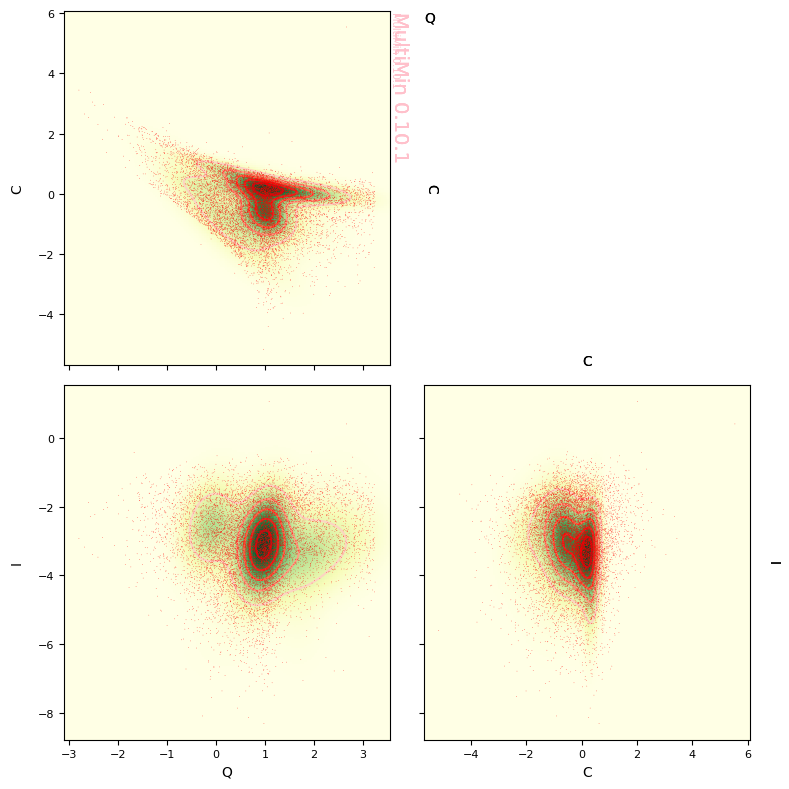

In [37]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

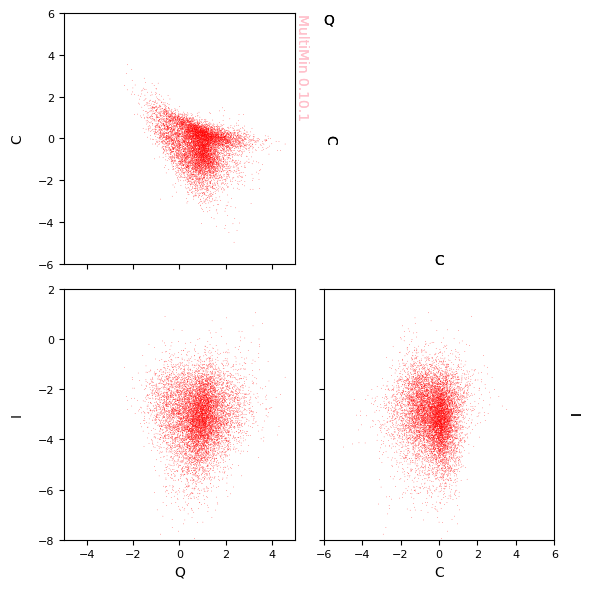

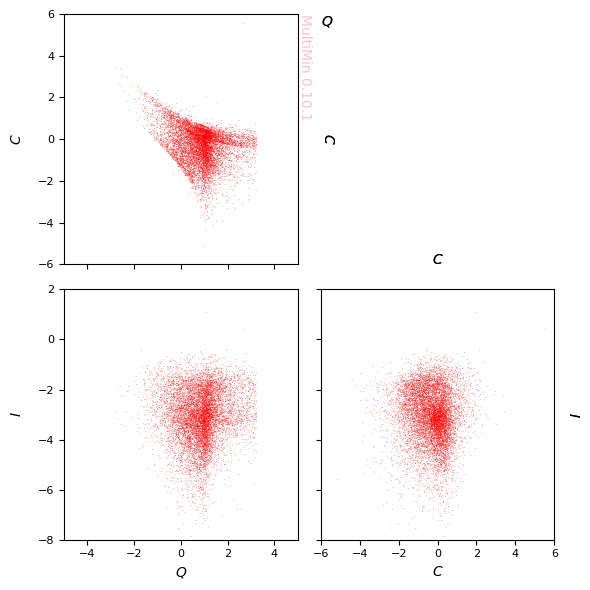

In [38]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

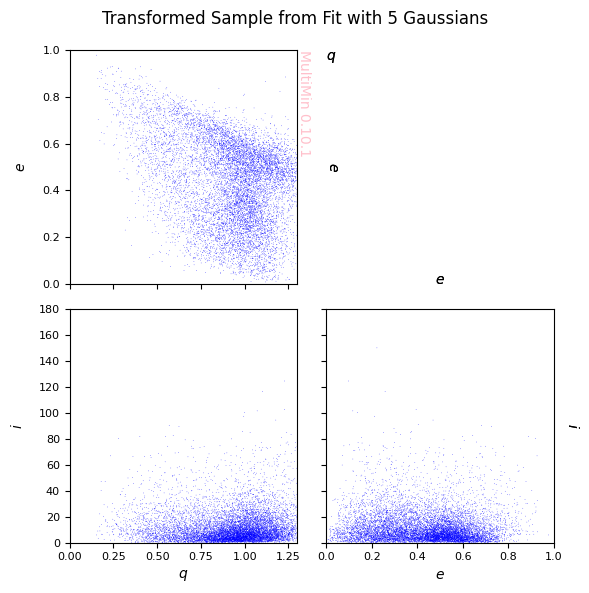

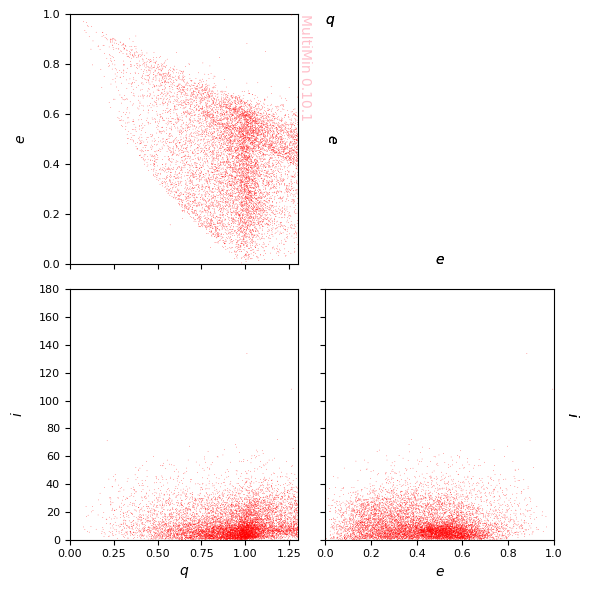

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

In [41]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 1.359616
    mu1_e = -0.894352
    mu1_i = -3.520807
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.648674, -0.049123, 0.734555], [-0.049123, 0.612773, 0.020985], [0.734555, 0.020985, 2.040674]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 1.011174
    mu2_e = -0.585299
    mu2_i = -2.893655
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.116708, -0.064706, 0.095129], [-0.064706, 0.324682, -0.134691], [0.095129, -0.134691, 0.859995]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 0.535164
    mu3_e = 0.560906
    mu3_i = -3.734012
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.414589, -0.210342, -0.125731], [-0.210342, 0.146661, 0.128046], [-0.125731, 0.128046, 1.480526]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 1.350447
    mu4_e = 0.105568
    mu4_i = -3.140508
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.787171, -0.111638, 0.182058], [-0.111638, 0.075958, 0.033849], [0.182058, 0.033849, 0.66667]]
    n4 = Util.nmd(

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga